Import package

In [1]:
# import required module
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import matplotlib.pyplot as plt
import cv2  #import Image read package
import albumentations as albu  # import required packages for data augmentation
from icecream import ic

# import modules for data extraction, augmentation, and preprocessing
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [2]:
# Set directory of files
DATA_DIR = r'C:\Users\user\Desktop\Psoriasis\Psoriasis_Dataset\Psoriasis_Train'

xTrainDir = os.path.join(DATA_DIR,'Psoriasis_Train_Image') #set Train Images dir
# bodyTrainDir = os.path.join(DATA_DIR,'Psoriasis_Train_Label_Body')  #set Train body Label Images dir
psoriasisTrainDir = os.path.join(DATA_DIR,'Psoriasis_Train_Label_Plaque')

xValidDir = os.path.join(DATA_DIR,'Psoriasis_Valid_Image')   #set Validation Images dir
# bodyValidDir = os.path.join(DATA_DIR,'Psoriasis_Valid_Label_Body')   #set Validation body Label Images dir 
psoriasisValidDir = os.path.join(DATA_DIR,'Psoriasis_Valid_Label_Plaque')

xTestDir = os.path.join(DATA_DIR,'Psoriasis_Valid_Image')  #set Test Images dir
# bodyTestDir = os.path.join(DATA_DIR,'Psoriasis_Valid_Label_Body')  #set Test body Label Images dir
psoriasisTestDir = os.path.join(DATA_DIR,'Psoriasis_Valid_Label_Plaque')



In [3]:
# Helper function for data visualization

def visualize(**images):
  n = len(images)
  plt.figure(figsize = (16,5)) 
  for i, (name, image) in enumerate(images.items()):
    plt.subplot(1, n, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(' '.join(name.split('_')).title())
    plt.imshow(image)
  plt.show()

In [4]:
#  Define class for data extraction, augmentation, and preprocessing

class Dataset(BaseDataset):

  CLASSES = ['body','background'] #Classes of Image mask
  # CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
  #            'tree', 'signsymbol', 'fence', 'car',
  #            'pedestrian', 'bicycclist', 'unlabelled']

  def __init__(
      self,
      imagesDir,
      annotationDir,
      classes = None,
      augmentation = None,
      preprocessing = None,
  ):
    self.ids = os.listdir(imagesDir)   
    self.imagesFps = [os.path.join(imagesDir,imageID) for imageID in self.ids]  
    self.annotationsFps = [os.path.join(annotationDir,imageID) for imageID in self.ids]
    self.classValues = [self.CLASSES.index(cls.lower()) for cls in classes]
    self.augmentation = augmentation
    self.preprocessing = preprocessing

  def __getitem__(self,i):

    # read data
    image  = cv2.imread(self.imagesFps[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.stack(image)
    annotation = cv2.imread(self.annotationsFps[i],0)  

    #extract certain classes from annotation (Like- Body)
    annotations = [(annotation == v) for v in self.classValues]
    annotation = np.stack(annotations, axis = -1).astype('float')
    annotation = np.logical_not(annotation)
    annotation = np.array(annotation, dtype='int16')

    # apply augmentations
    if self.augmentation:
      sample = self.augmentation(image=image, mask=annotation)
      image, annotation = sample['image'], sample['mask']

    # Apply preprocessing
    if self.preprocessing:
      sample = self.preprocessing(image=image, mask=annotation)
      image, annotation = sample['image'], sample['mask']
    
    return image,annotation

  def __len__(self):
    return len(self.ids)


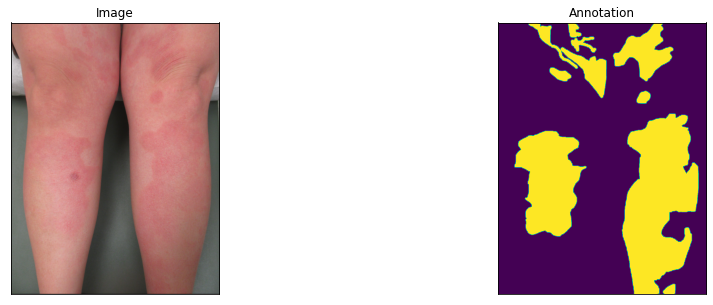

In [5]:
# Let's look at data we have

dataset = Dataset(xTrainDir,psoriasisTrainDir,classes=['Body']) # Check specific class to see the Image annotation

image, annotation = dataset[3] # get a sample

visualize(
    image = image,
    annotation = annotation.squeeze(),
)

In [6]:
# define function for data augmentation
def getTrainingAugmentation():
  trainTransform = [
                    albu.HorizontalFlip(p=0.5), # horizontal flip 50%

                    albu.ShiftScaleRotate(scale_limit = 0.5, rotate_limit = 0, shift_limit = 0.1, p = 1, border_mode = cv2.BORDER_REPLICATE),

                    albu.PadIfNeeded(min_height=480, min_width=320, always_apply=True, border_mode= 0),
                    albu.RandomCrop(height=480, width=320, always_apply=False),

                    albu.IAAAdditiveGaussianNoise(p=0.2),
                    albu.IAAPerspective(p=0.5),
                                        
                    albu.OneOf(
                        [
                         albu.CLAHE(p=1),
                         albu.RandomBrightness(p=1),
                         albu.RandomGamma(p=1),
                        ],
                        p=0.9,
                    ),

                    albu.OneOf(
                        [
                         albu.IAASharpen(p=1),
                         albu.Blur(blur_limit=3, p=1),
                         albu.MotionBlur(blur_limit=3, p=1),
                        ],
                        p=0.9,
                    ),

                    albu.OneOf(
                        [
                         albu.RandomContrast(p=1),
                         albu.HueSaturationValue(p=1),
                        ],
                        p=0.9,
                    ),                    
  ]
  return albu.Compose(trainTransform)

def getValidationAugmentation():
  # add padding to make image shape divisible by 32
  testTransform = [
                   albu.PadIfNeeded(320,480) # change value 384,480 to 320,320
  ]
  return albu.Compose(testTransform)

def toTensor(x,**kwargs):
  return x.transpose(2, 0, 1).astype('float32')

def getPreprocessing(preprocessingFcn):
  # construct prprocessing transform

  _transform = [
                albu.Lambda(image = preprocessingFcn),
                albu.Lambda(image = toTensor, mask= toTensor),
  ]
  return albu.Compose(_transform)

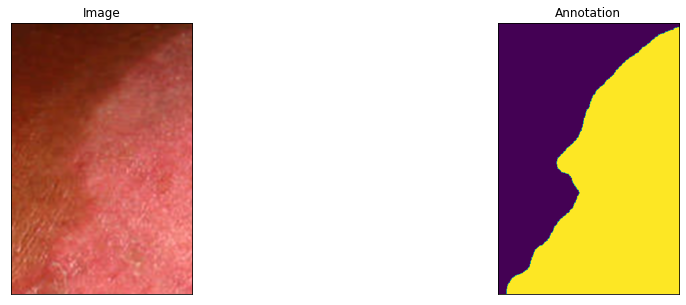

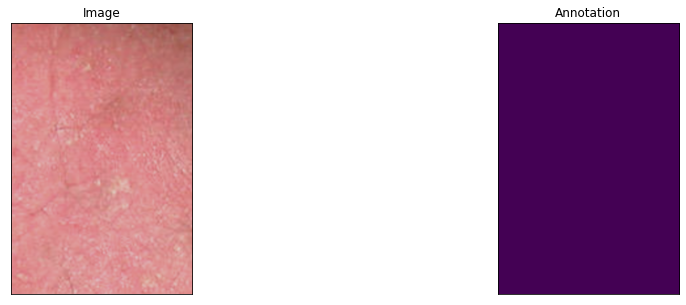

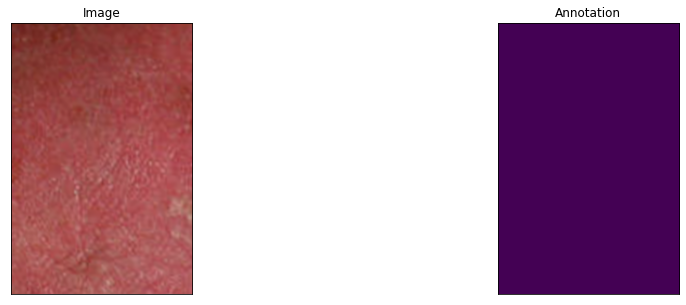

In [7]:
#  Visualize resulted augmented images and annotations
augmentedDataset = Dataset(
    xTrainDir,
    psoriasisTrainDir,
    augmentation = getTrainingAugmentation(),
    classes=['body'],
)

# same image with different random transforms
for i in range(3):
  image, annotation = augmentedDataset[60]
  visualize(image=image, annotation =annotation.squeeze(-1))


In [8]:
# Import required package for create and train model
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [30]:
#encoderName=['resnet18','resnet34','resnet50','resnet101','resnet152']
#encoderName= ['timm-resnest14d','timm-resnest26d','timm-resnest50d','timm-resnest101e','timm-resnest200e','timm-resnest269e','timm-resnest50d_4s2x40d','timm-resnest50d_1s4x24d']
encoderName = ['timm-efficientnet-b5','timm-efficientnet-b6','timm-efficientnet-b7','timm-efficientnet-b8']

for j in encoderName:
  print('Start Training....')
  ic(j)
  # create model
  ENCODER = j # Default "se_resnext50_32x4d"
  ENCODER_WEIGHTS = 'imagenet'
  CLASSES = ['body']
  ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
  # DEVICE = 'cuda'

  # create segmentation model with pretrained encoder
  model = smp.FPN(
      encoder_name=ENCODER, 
      encoder_weights=ENCODER_WEIGHTS, 
      classes=len(CLASSES), 
      activation=ACTIVATION,
  )

  preprocessingFcn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

    # Data load

  # Load Dataset for Train
  trainDataset = Dataset(
      xTrainDir, 
      psoriasisTrainDir, 
      augmentation=getTrainingAugmentation(), 
      preprocessing=getPreprocessing(preprocessingFcn),
      classes=CLASSES,
  )

  # Load Dataset for Valid
  validDataset = Dataset(
      xValidDir, 
      psoriasisValidDir, 
      augmentation=getTrainingAugmentation(), 
      preprocessing=getPreprocessing(preprocessingFcn),
      classes=CLASSES,
  )

  trainLoader = DataLoader(trainDataset, batch_size=5, shuffle=True, num_workers=0)
  validLoader = DataLoader(validDataset, batch_size=1, shuffle=False, num_workers=0)

  # Set train parameters
  loss = smp.utils.losses.DiceLoss()

  metrics = [
            smp.utils.metrics.IoU(threshold=0.5),
            smp.utils.metrics.Fscore(threshold=0.5),
            smp.utils.metrics.Accuracy(threshold=0.5),
            smp.utils.metrics.Recall(threshold=0.5),
            smp.utils.metrics.Precision(threshold=0.5),
  ]

  optimizer = torch.optim.Adam([
                                dict(params = model.parameters(), lr =0.001),
  ])

    # create epoch runners 
  # it is a simple loop of iterating over dataloader`s samples
  train_epoch = smp.utils.train.TrainEpoch(
      model,
      loss=loss,
      metrics=metrics,
      optimizer=optimizer,
      verbose=True,
  )

  valid_epoch =smp.utils.train.ValidEpoch(
      model,loss=loss,
      metrics=metrics,
      verbose=True,
  )

  # train model for 50 epochs

  max_score =0
  for i in range(0,50):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(trainLoader)
    valid_logs = valid_epoch.run(validLoader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
      max_score = valid_logs['iou_score']
      torch.save(model,'./best_model.pth')
      print('Model saved!')
      ic(ENCODER)

    if i ==20:
      optimizer.param_groups[0]['lr'] = 1e-4
      print('Decrease decoder learning rate to 1e-4!')
    
    if i ==40:
      optimizer.param_groups[0]['lr'] = 1e-5
      print('Decrease decoder learning rate to 1e-5!')

  print('Complete Training....')
  ic(j)

ic| j: 'timm-efficientnet-b5'


Start Training....

Epoch: 0
train: 100%|█| 14/14 [46:11<00:00, 197.98s/it, dice_loss - 0.3798, iou_score - 0.4846, fscore - 0.624, accuracy - 0.774
valid: 100%|█| 15/15 [00:33<00:00,  2.22s/it, dice_loss - 0.5551, iou_score - 0.4097, fscore - 0.5054, accuracy - 0.793
Model saved!

ic| ENCODER: 'timm-efficientnet-b5'




Epoch: 1
train: 100%|█| 14/14 [46:20<00:00, 198.63s/it, dice_loss - 0.2224, iou_score - 0.6485, fscore - 0.7807, accuracy - 0.89
valid: 100%|█| 15/15 [00:33<00:00,  2.21s/it, dice_loss - 0.3675, iou_score - 0.5426, fscore - 0.6405, accuracy - 0.826

ic


Model saved!


| ENCODER: 'timm-efficientnet-b5'



Epoch: 2
train: 100%|█| 14/14 [45:44<00:00, 196.00s/it, dice_loss - 0.2274, iou_score - 0.6455, fscore - 0.7742, accuracy - 0.88
valid: 100%|█| 15/15 [00:33<00:00,  2.21s/it, dice_loss - 0.3341, iou_score - 0.5777, fscore - 0.6656, accuracy - 0.847
Model saved!

ic| ENCODER: 'timm-efficientnet-b5'




Epoch: 3
train: 100%|█| 14/14 [45:42<00:00, 195.87s/it, dice_loss - 0.1981, iou_score - 0.6794, fscore - 0.8032, accuracy - 0.90
valid: 100%|█| 15/15 [00:35<00:00,  2.34s/it, dice_loss - 0.4225, iou_score - 0.4702, fscore - 0.5844, accuracy - 0.774

Epoch: 4
train: 100%|█| 14/14 [45:36<00:00, 195.47s/it, dice_loss - 0.1859, iou_score - 0.7111, fscore - 0.8157, accuracy - 0.89
valid: 100%|█| 15/15 [00:34<00:00,  2.30s/it, dice_loss - 0.4925, iou_score - 0.4009, fscore - 0.5059, accuracy - 0.766

Epoch: 5
train: 100%|█| 14/14 [45:59<00:00, 197.08s/it, dice_loss - 0.16, iou_score - 0.7332, fscore - 0.8412, accuracy - 0.9226
valid: 100%|█| 15/15 [00:33<00:00,  2.20s/it, dice_loss - 0.4568, iou_score - 0.4613, fscore - 0.5441, accuracy - 0.729

Epoch: 6
train: 100%|█| 14/14 [45:34<00:00, 195.29s/it, dice_loss - 0.2252, iou_score - 0.6576, fscore - 0.7763, accuracy - 0.92
valid: 100%|█| 15/15 [00:33<00:00,  2.24s/it, dice_loss - 0.2817, iou_score - 0.6047, fscore - 0.7189, accuracy - 0.845

ic| ENCODER: 'timm-efficientnet-b5'



Epoch: 7
train: 100%|█| 14/14 [45:45<00:00, 196.08s/it, dice_loss - 0.2378, iou_score - 0.6373, fscore - 0.7636, accuracy - 0.89
valid: 100%|█| 15/15 [00:34<00:00,  2.27s/it, dice_loss - 0.2379, iou_score - 0.6397, fscore - 0.7628, accuracy - 0.845

ic


Model saved!


| ENCODER: 'timm-efficientnet-b5'



Epoch: 8
train: 100%|█| 14/14 [45:37<00:00, 195.54s/it, dice_loss - 0.1908, iou_score - 0.698, fscore - 0.811, accuracy - 0.919,
valid: 100%|█| 15/15 [00:34<00:00,  2.29s/it, dice_loss - 0.3093, iou_score - 0.5796, fscore - 0.6903, accuracy - 0.784

Epoch: 9
train: 100%|█| 14/14 [45:45<00:00, 196.14s/it, dice_loss - 0.1314, iou_score - 0.7825, fscore - 0.8704, accuracy - 0.94
valid: 100%|█| 15/15 [00:33<00:00,  2.23s/it, dice_loss - 0.3008, iou_score - 0.6127, fscore - 0.6995, accuracy - 0.838

Epoch: 10
train: 100%|█| 14/14 [45:53<00:00, 196.66s/it, dice_loss - 0.1392, iou_score - 0.7699, fscore - 0.8632, accuracy - 0.93
valid: 100%|█| 15/15 [00:34<00:00,  2.27s/it, dice_loss - 0.3717, iou_score - 0.5075, fscore - 0.6269, accuracy - 0.803

Epoch: 11
train: 100%|█| 14/14 [45:45<00:00, 196.09s/it, dice_loss - 0.1778, iou_score - 0.7109, fscore - 0.824, accuracy - 0.925
valid: 100%|█| 15/15 [00:33<00:00,  2.24s/it, dice_loss - 0.4265, iou_score - 0.5239, fscore - 0.6195, accuracy - 0.77

ic| ENCODER: 'timm-efficientnet-b5'



Epoch: 17
train: 100%|█| 14/14 [45:51<00:00, 196.56s/it, dice_loss - 0.1847, iou_score - 0.7047, fscore - 0.8163, accuracy - 0.91
valid: 100%|█| 15/15 [00:34<00:00,  2.29s/it, dice_loss - 0.2407, iou_score - 0.6621, fscore - 0.76, accuracy - 0.8784,
Model saved!

ic| ENCODER: 'timm-efficientnet-b5'




Epoch: 18
train: 100%|█| 14/14 [46:02<00:00, 197.31s/it, dice_loss - 0.1409, iou_score - 0.7688, fscore - 0.8603, accuracy - 0.93
valid: 100%|█| 15/15 [00:33<00:00,  2.22s/it, dice_loss - 0.4418, iou_score - 0.491, fscore - 0.5827, accuracy - 0.7606

Epoch: 19
train: 100%|█| 14/14 [46:04<00:00, 197.46s/it, dice_loss - 0.135, iou_score - 0.7706, fscore - 0.8668, accuracy - 0.939
valid: 100%|█| 15/15 [00:33<00:00,  2.23s/it, dice_loss - 0.4731, iou_score - 0.4194, fscore - 0.5269, accuracy - 0.693

Epoch: 20
train: 100%|█| 14/14 [45:51<00:00, 196.51s/it, dice_loss - 0.1338, iou_score - 0.7739, fscore - 0.8675, accuracy - 0.93
valid: 100%|█| 15/15 [00:34<00:00,  2.28s/it, dice_loss - 0.3269, iou_score - 0.5725, fscore - 0.6731, accuracy - 0.786
Decrease decoder learning rate to 1e-4!

Epoch: 21
train: 100%|█| 14/14 [46:08<00:00, 197.77s/it, dice_loss - 0.1582, iou_score - 0.747, fscore - 0.8433, accuracy - 0.939
valid: 100%|█| 15/15 [00:33<00:00,  2.25s/it, dice_loss - 0.3741, iou_score

ic| ENCODER: 'timm-efficientnet-b5'




Epoch: 30
train: 100%|█| 14/14 [46:39<00:00, 199.94s/it, dice_loss - 0.137, iou_score - 0.7696, fscore - 0.8643, accuracy - 0.937
valid: 100%|█| 15/15 [00:34<00:00,  2.31s/it, dice_loss - 0.33, iou_score - 0.5733, fscore - 0.6707, accuracy - 0.8438,

Epoch: 31
train: 100%|█| 14/14 [46:20<00:00, 198.60s/it, dice_loss - 0.1391, iou_score - 0.7655, fscore - 0.8618, accuracy - 0.94
valid: 100%|█| 15/15 [00:34<00:00,  2.32s/it, dice_loss - 0.3658, iou_score - 0.543, fscore - 0.6339, accuracy - 0.8303

Epoch: 32
train: 100%|█| 14/14 [46:23<00:00, 198.84s/it, dice_loss - 0.1475, iou_score - 0.7646, fscore - 0.8534, accuracy - 0.94
valid: 100%|█| 15/15 [00:35<00:00,  2.34s/it, dice_loss - 0.3851, iou_score - 0.4967, fscore - 0.615, accuracy - 0.7763

Epoch: 33
train: 100%|█| 14/14 [46:22<00:00, 198.74s/it, dice_loss - 0.1075, iou_score - 0.8107, fscore - 0.8937, accuracy - 0.95
valid: 100%|█| 15/15 [00:35<00:00,  2.35s/it, dice_loss - 0.3442, iou_score - 0.5313, fscore - 0.6551, accuracy - 0

ic| j: 'timm-efficientnet-b5'
ic| j: 'timm-efficientnet-b6'



Complete Training....
Start Training....

Epoch: 0
train: 100%|█| 14/14 [1:12:25<00:00, 310.41s/it, dice_loss - 0.3766, iou_score - 0.4793, fscore - 0.6266, accuracy - 0.
valid: 100%|█| 15/15 [00:45<00:00,  3.02s/it, dice_loss - 0.4152, iou_score - 0.4745, fscore - 0.5844, accuracy - 0.815


ic| ENCODER: 'timm-efficientnet-b6'


Model saved!

Epoch: 1
train: 100%|█| 14/14 [1:14:29<00:00, 319.28s/it, dice_loss - 0.2778, iou_score - 0.5849, fscore - 0.7238, accuracy - 0.
valid: 100%|█| 15/15 [00:48<00:00,  3.25s/it, dice_loss - 0.3425, iou_score - 0.5491, fscore - 0.6574, accuracy - 0.802


ic| ENCODER: 'timm-efficientnet-b6'


Model saved!

Epoch: 2
train: 100%|█| 14/14 [1:12:53<00:00, 312.37s/it, dice_loss - 0.193, iou_score - 0.6916, fscore - 0.8099, accuracy - 0.9
valid: 100%|█| 15/15 [00:45<00:00,  3.06s/it, dice_loss - 0.3173, iou_score - 0.5728, fscore - 0.6839, accuracy - 0.863


ic| ENCODER: 'timm-efficientnet-b6'


Model saved!

Epoch: 3
train: 100%|█| 14/14 [1:14:52<00:00, 320.89s/it, dice_loss - 0.1787, iou_score - 0.7124, fscore - 0.823, accuracy - 0.9
valid: 100%|█| 15/15 [00:46<00:00,  3.13s/it, dice_loss - 0.1581, iou_score - 0.7411, fscore - 0.8429, accuracy - 0.898


ic| ENCODER: 'timm-efficientnet-b6'


Model saved!

Epoch: 4
train: 100%|█| 14/14 [1:13:36<00:00, 315.49s/it, dice_loss - 0.1613, iou_score - 0.7371, fscore - 0.8406, accuracy - 0.
valid: 100%|█| 15/15 [00:45<00:00,  3.06s/it, dice_loss - 0.3706, iou_score - 0.5078, fscore - 0.6292, accuracy - 0.814

Epoch: 5
train: 100%|█| 14/14 [1:50:43<00:00, 474.54s/it, dice_loss - 0.1884, iou_score - 0.6958, fscore - 0.8137, accuracy - 0.
valid: 100%|█| 15/15 [01:12<00:00,  4.86s/it, dice_loss - 0.3099, iou_score - 0.5722, fscore - 0.6914, accuracy - 0.866

Epoch: 6
train: 100%|█| 14/14 [1:59:43<00:00, 513.14s/it, dice_loss - 0.1526, iou_score - 0.7486, fscore - 0.8493, accuracy - 0.
valid: 100%|█| 15/15 [01:20<00:00,  5.36s/it, dice_loss - 0.4842, iou_score - 0.4379, fscore - 0.5159, accuracy - 0.723

Epoch: 7
train: 100%|█| 14/14 [1:59:35<00:00, 512.52s/it, dice_loss - 0.173, iou_score - 0.7139, fscore - 0.8276, accuracy - 0.9
valid: 100%|█| 15/15 [01:13<00:00,  4.90s/it, dice_loss - 0.5132, iou_score - 0.3883, fscore - 0.4856, accu

train: 100%|█| 14/14 [1:24:02<00:00, 360.19s/it, dice_loss - 0.1125, iou_score - 0.8042, fscore - 0.8889, accuracy - 0.
valid: 100%|█| 15/15 [00:51<00:00,  3.45s/it, dice_loss - 0.4239, iou_score - 0.4793, fscore - 0.5759, accuracy - 0.796

Epoch: 37
train: 100%|█| 14/14 [1:25:21<00:00, 365.83s/it, dice_loss - 0.08013, iou_score - 0.8549, fscore - 0.9209, accuracy - 0
valid: 100%|█| 15/15 [00:51<00:00,  3.41s/it, dice_loss - 0.3223, iou_score - 0.5528, fscore - 0.6778, accuracy - 0.808

Epoch: 38
train: 100%|█| 14/14 [1:23:49<00:00, 359.21s/it, dice_loss - 0.09924, iou_score - 0.8253, fscore - 0.9017, accuracy - 0
valid: 100%|█| 15/15 [00:51<00:00,  3.43s/it, dice_loss - 0.3589, iou_score - 0.5448, fscore - 0.6405, accuracy - 0.874

Epoch: 39
train: 100%|█| 14/14 [1:25:32<00:00, 366.59s/it, dice_loss - 0.11, iou_score - 0.8115, fscore - 0.8912, accuracy - 0.95
valid: 100%|█| 15/15 [00:50<00:00,  3.36s/it, dice_loss - 0.2926, iou_score - 0.622, fscore - 0.7091, accuracy - 0.8277

Epoch:

ic| j: 'timm-efficientnet-b6'
ic| j: 'timm-efficientnet-b7'



Complete Training....
Start Training....

Epoch: 0
train: 100%|█| 14/14 [2:24:17<00:00, 618.38s/it, dice_loss - 0.3984, iou_score - 0.4495, fscore - 0.6038, accuracy - 0.
valid: 100%|█| 15/15 [01:14<00:00,  4.99s/it, dice_loss - 0.3482, iou_score - 0.523, fscore - 0.6524, accuracy - 0.7703


ic| ENCODER: 'timm-efficientnet-b7'


Model saved!

Epoch: 1
train: 100%|█| 14/14 [2:25:00<00:00, 621.44s/it, dice_loss - 0.3373, iou_score - 0.5116, fscore - 0.664, accuracy - 0.8
valid: 100%|█| 15/15 [01:19<00:00,  5.29s/it, dice_loss - 0.3703, iou_score - 0.5909, fscore - 0.6958, accuracy - 0.832


ic| ENCODER: 'timm-efficientnet-b7'


Model saved!

Epoch: 2
train: 100%|█| 14/14 [2:06:32<00:00, 542.30s/it, dice_loss - 0.2638, iou_score - 0.5977, fscore - 0.7378, accuracy - 0.
valid: 100%|█| 15/15 [01:15<00:00,  5.00s/it, dice_loss - 0.4126, iou_score - 0.4602, fscore - 0.5862, accuracy - 0.767

Epoch: 3
train: 100%|█| 14/14 [1:55:22<00:00, 494.44s/it, dice_loss - 0.2161, iou_score - 0.6604, fscore - 0.7855, accuracy - 0.
valid: 100%|█| 15/15 [01:13<00:00,  4.92s/it, dice_loss - 0.3434, iou_score - 0.5431, fscore - 0.6564, accuracy - 0.855

Epoch: 4
train: 100%|█| 14/14 [2:02:30<00:00, 525.02s/it, dice_loss - 0.288, iou_score - 0.5706, fscore - 0.7134, accuracy - 0.8
valid: 100%|█| 15/15 [01:15<00:00,  5.01s/it, dice_loss - 0.2697, iou_score - 0.6284, fscore - 0.7449, accuracy - 0.818


ic| ENCODER: 'timm-efficientnet-b7'


Model saved!

Epoch: 5
train: 100%|█| 14/14 [2:11:37<00:00, 564.09s/it, dice_loss - 0.1617, iou_score - 0.7294, fscore - 0.8395, accuracy - 0.
valid: 100%|█| 15/15 [01:15<00:00,  5.01s/it, dice_loss - 0.5237, iou_score - 0.3824, fscore - 0.4751, accuracy - 0.623

Epoch: 6
train: 100%|█| 14/14 [2:16:17<00:00, 584.13s/it, dice_loss - 0.1387, iou_score - 0.7636, fscore - 0.8626, accuracy - 0.
valid: 100%|█| 15/15 [01:15<00:00,  5.00s/it, dice_loss - 0.3708, iou_score - 0.5604, fscore - 0.6618, accuracy - 0.813

Epoch: 7
train: 100%|█| 14/14 [2:16:14<00:00, 583.88s/it, dice_loss - 0.1552, iou_score - 0.747, fscore - 0.8463, accuracy - 0.9
valid: 100%|█| 15/15 [01:13<00:00,  4.92s/it, dice_loss - 0.2814, iou_score - 0.5952, fscore - 0.7182, accuracy - 0.838

Epoch: 8
train: 100%|█| 14/14 [2:16:10<00:00, 583.58s/it, dice_loss - 0.2088, iou_score - 0.6682, fscore - 0.7932, accuracy - 0.
valid: 100%|█| 15/15 [01:15<00:00,  5.07s/it, dice_loss - 0.4276, iou_score - 0.4546, fscore - 0.5722, accu

ic| ENCODER: 'timm-efficientnet-b7'


Model saved!

Epoch: 12
train: 100%|█| 14/14 [2:14:15<00:00, 575.38s/it, dice_loss - 0.1773, iou_score - 0.7047, fscore - 0.8242, accuracy - 0.
valid: 100%|█| 15/15 [01:17<00:00,  5.19s/it, dice_loss - 0.5973, iou_score - 0.3312, fscore - 0.4034, accuracy - 0.647

Epoch: 13
train: 100%|█| 14/14 [2:16:20<00:00, 584.35s/it, dice_loss - 0.1766, iou_score - 0.7217, fscore - 0.8244, accuracy - 0.
valid: 100%|█| 15/15 [01:18<00:00,  5.21s/it, dice_loss - 0.4473, iou_score - 0.4349, fscore - 0.5532, accuracy - 0.786

Epoch: 14
train: 100%|█| 14/14 [2:16:23<00:00, 584.52s/it, dice_loss - 0.1524, iou_score - 0.7425, fscore - 0.8489, accuracy - 0.
valid: 100%|█| 15/15 [01:16<00:00,  5.11s/it, dice_loss - 0.3217, iou_score - 0.5791, fscore - 0.6785, accuracy - 0.820

Epoch: 15
train: 100%|█| 14/14 [2:17:12<00:00, 588.03s/it, dice_loss - 0.174, iou_score - 0.7257, fscore - 0.8271, accuracy - 0.9
valid: 100%|█| 15/15 [01:18<00:00,  5.25s/it, dice_loss - 0.2979, iou_score - 0.5826, fscore - 0.7041, 

ic| ENCODER: 'timm-efficientnet-b7'


Model saved!

Epoch: 28
train: 100%|█| 14/14 [2:26:58<00:00, 629.87s/it, dice_loss - 0.1341, iou_score - 0.7884, fscore - 0.867, accuracy - 0.9
valid: 100%|█| 15/15 [01:14<00:00,  5.00s/it, dice_loss - 0.3185, iou_score - 0.5636, fscore - 0.6816, accuracy - 0.804

Epoch: 29
train: 100%|█| 14/14 [2:25:17<00:00, 622.71s/it, dice_loss - 0.118, iou_score - 0.7985, fscore - 0.883, accuracy - 0.94
valid: 100%|█| 15/15 [01:14<00:00,  4.98s/it, dice_loss - 0.3325, iou_score - 0.5524, fscore - 0.6689, accuracy - 0.842

Epoch: 30
train: 100%|█| 14/14 [2:25:47<00:00, 624.83s/it, dice_loss - 0.1231, iou_score - 0.787, fscore - 0.8785, accuracy - 0.9
valid: 100%|█| 15/15 [01:15<00:00,  5.02s/it, dice_loss - 0.4377, iou_score - 0.4863, fscore - 0.5911, accuracy - 0.761

Epoch: 31
train: 100%|█| 14/14 [2:26:14<00:00, 626.75s/it, dice_loss - 0.1712, iou_score - 0.7276, fscore - 0.8294, accuracy - 0.
valid: 100%|█| 15/15 [01:17<00:00,  5.19s/it, dice_loss - 0.3443, iou_score - 0.5253, fscore - 0.655, a

ic| ENCODER: 'timm-efficientnet-b7'


Model saved!

Epoch: 40
train: 100%|█| 14/14 [2:25:13<00:00, 622.37s/it, dice_loss - 0.1082, iou_score - 0.8135, fscore - 0.893, accuracy - 0.9
valid: 100%|█| 15/15 [01:17<00:00,  5.16s/it, dice_loss - 0.2944, iou_score - 0.6159, fscore - 0.7062, accuracy - 0.853
Decrease decoder learning rate to 1e-5!

Epoch: 41
train: 100%|█| 14/14 [2:26:41<00:00, 628.70s/it, dice_loss - 0.1134, iou_score - 0.8029, fscore - 0.8875, accuracy - 0.
valid: 100%|█| 15/15 [01:19<00:00,  5.28s/it, dice_loss - 0.3968, iou_score - 0.4991, fscore - 0.6037, accuracy - 0.809

Epoch: 42
train: 100%|█| 14/14 [2:25:56<00:00, 625.49s/it, dice_loss - 0.09926, iou_score - 0.8265, fscore - 0.9018, accuracy - 0
valid: 100%|█| 15/15 [01:18<00:00,  5.20s/it, dice_loss - 0.4924, iou_score - 0.4009, fscore - 0.507, accuracy - 0.7386

Epoch: 43
train: 100%|█| 14/14 [2:27:05<00:00, 630.37s/it, dice_loss - 0.1264, iou_score - 0.7875, fscore - 0.8742, accuracy - 0.
valid: 100%|█| 15/15 [01:14<00:00,  4.95s/it, dice_loss - 0.307

ic| j: 'timm-efficientnet-b7'
ic| j: 'timm-efficientnet-b8'


Start Training....

Epoch: 0
train: 100%|█| 14/14 [3:36:54<00:00, 929.58s/it, dice_loss - 0.3958, iou_score - 0.4505, fscore - 0.6079, accuracy - 0.
valid: 100%|█| 15/15 [01:44<00:00,  6.97s/it, dice_loss - 0.3528, iou_score - 0.5447, fscore - 0.6472, accuracy - 0.804


ic| ENCODER: 'timm-efficientnet-b8'


Model saved!

Epoch: 1
train: 100%|█| 14/14 [3:34:38<00:00, 919.90s/it, dice_loss - 0.2561, iou_score - 0.6017, fscore - 0.7456, accuracy - 0.
valid: 100%|█| 15/15 [01:43<00:00,  6.91s/it, dice_loss - 0.373, iou_score - 0.528, fscore - 0.659, accuracy - 0.8072, 

Epoch: 2
train: 100%|█| 14/14 [3:36:30<00:00, 927.93s/it, dice_loss - 0.275, iou_score - 0.5898, fscore - 0.7265, accuracy - 0.8
valid: 100%|█| 15/15 [01:42<00:00,  6.86s/it, dice_loss - 0.3088, iou_score - 0.5649, fscore - 0.6919, accuracy - 0.841


ic| ENCODER: 'timm-efficientnet-b8'


Model saved!

Epoch: 3
train: 100%|█| 14/14 [3:35:25<00:00, 923.22s/it, dice_loss - 0.2427, iou_score - 0.6267, fscore - 0.7585, accuracy - 0.
valid: 100%|█| 15/15 [01:43<00:00,  6.92s/it, dice_loss - 0.353, iou_score - 0.5324, fscore - 0.6477, accuracy - 0.7622

Epoch: 4
train: 100%|█| 14/14 [3:37:51<00:00, 933.70s/it, dice_loss - 0.2737, iou_score - 0.5838, fscore - 0.7275, accuracy - 0.
valid: 100%|█| 15/15 [01:43<00:00,  6.87s/it, dice_loss - 0.3327, iou_score - 0.5471, fscore - 0.676, accuracy - 0.7795

Epoch: 5
train: 100%|█| 14/14 [3:38:04<00:00, 934.57s/it, dice_loss - 0.2385, iou_score - 0.6324, fscore - 0.7628, accuracy - 0.
valid: 100%|█| 15/15 [01:41<00:00,  6.78s/it, dice_loss - 0.3009, iou_score - 0.5914, fscore - 0.7, accuracy - 0.8339, 


ic| ENCODER: 'timm-efficientnet-b8'


Model saved!

Epoch: 6
train: 100%|█| 14/14 [3:36:18<00:00, 927.01s/it, dice_loss - 0.1906, iou_score - 0.7033, fscore - 0.8114, accuracy - 0.
valid: 100%|█| 15/15 [01:42<00:00,  6.82s/it, dice_loss - 0.1719, iou_score - 0.7235, fscore - 0.8302, accuracy - 0.867


ic| ENCODER: 'timm-efficientnet-b8'


Model saved!

Epoch: 7
train: 100%|█| 14/14 [3:36:58<00:00, 929.86s/it, dice_loss - 0.1556, iou_score - 0.7479, fscore - 0.8459, accuracy - 0.
valid: 100%|█| 15/15 [01:40<00:00,  6.70s/it, dice_loss - 0.3735, iou_score - 0.5036, fscore - 0.6154, accuracy - 0.848

Epoch: 8
train: 100%|█| 14/14 [3:36:34<00:00, 928.15s/it, dice_loss - 0.1734, iou_score - 0.7205, fscore - 0.8288, accuracy - 0.
valid: 100%|█| 15/15 [01:41<00:00,  6.77s/it, dice_loss - 0.3089, iou_score - 0.5974, fscore - 0.6938, accuracy - 0.836

Epoch: 9
train:  21%|▏| 3/14 [1:00:09<3:40:35, 1203.24s/it, dice_loss - 0.2142, iou_score - 0.6521, fscore - 0.7884, accuracy - 


KeyboardInterrupt: 

In [24]:
# create model
ENCODER = 'timm-efficientnet-b0' # DEFAULT "se_resnext50_32x4d"
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['body']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessingFcn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [25]:
# Data load

# Load Dataset for Train
trainDataset = Dataset(
    xTrainDir, 
    psoriasisTrainDir, 
    augmentation=getTrainingAugmentation(), 
    preprocessing=getPreprocessing(preprocessingFcn),
    classes=CLASSES,
)

# Load Dataset for Valid
validDataset = Dataset(
    xValidDir, 
    psoriasisValidDir, 
    augmentation=getTrainingAugmentation(), 
    preprocessing=getPreprocessing(preprocessingFcn),
    classes=CLASSES,
)

trainLoader = DataLoader(trainDataset, batch_size=5, shuffle=True, num_workers=0)
validLoader = DataLoader(validDataset, batch_size=1, shuffle=False, num_workers=0)

In [26]:
# Set train parameters
loss = smp.utils.losses.DiceLoss()

metrics = [
           smp.utils.metrics.IoU(threshold=0.5),
           smp.utils.metrics.Fscore(threshold=0.5),
           smp.utils.metrics.Accuracy(threshold=0.5),
           smp.utils.metrics.Recall(threshold=0.5),
           smp.utils.metrics.Precision(threshold=0.5),
]

optimizer = torch.optim.Adam([
                              dict(params = model.parameters(), lr =0.0001),
])


In [27]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
#     device=DEVICE,
    verbose=True,
)

valid_epoch =smp.utils.train.ValidEpoch(
    model,loss=loss,
    metrics=metrics,
#     device=DEVICE,
    verbose=True,
)

In [28]:
# train model for 40 epochs

max_score =0
for i in range(0,50):
  print('\nEpoch: {}'.format(i))
  train_logs = train_epoch.run(trainLoader)
  valid_logs = valid_epoch.run(validLoader)

  # do something (save model, change lr, etc.)
  if max_score < valid_logs['iou_score']:
    max_score = valid_logs['iou_score']
    torch.save(model,'./best_model.pth')
    print('Model saved!')
    ic(ENCODER)

  if i ==25:
    optimizer.param_groups[0]['lr'] = 1e-5
    print('Decrease decoder learning rate to 1e-5!')



Epoch: 0
train: 100%|█| 14/14 [07:19<00:00, 31.36s/it, dice_loss - 0.509, iou_score - 0.3567, fscore - 0.5056, accuracy - 0.6536
valid: 100%|█| 15/15 [00:09<00:00,  1.59it/s, dice_loss - 0.5358, iou_score - 0.3278, fscore - 0.4529, accuracy - 0.716

ic| ENCODER: 'timm-efficientnet-b0'



Model saved!

Epoch: 1
train: 100%|█| 14/14 [07:20<00:00, 31.49s/it, dice_loss - 0.3219, iou_score - 0.5479, fscore - 0.6993, accuracy - 0.842
valid: 100%|█| 15/15 [00:10<00:00,  1.49it/s, dice_loss - 0.5019, iou_score - 0.3929, fscore - 0.4986, accuracy - 0.749

ic| ENCODER: 'timm-efficientnet-b0'



Model saved!

Epoch: 2
train: 100%|█| 14/14 [07:23<00:00, 31.67s/it, dice_loss - 0.3046, iou_score - 0.5621, fscore - 0.7082, accuracy - 0.861
valid: 100%|█| 15/15 [00:09<00:00,  1.65it/s, dice_loss - 0.4898, iou_score - 0.4015, fscore - 0.506, accuracy - 0.7601

ic| ENCODER: 'timm-efficientnet-b0'



Model saved!

Epoch: 3
train: 100%|█| 14/14 [07:26<00:00, 31.88s/it, dice_loss - 0.2734, iou_score - 0.6001, fscore - 0.7395, accuracy - 0.880
valid: 100%|█| 15/15 [00:09<00:00,  1.59it/s, dice_loss - 0.5376, iou_score - 0.3691, fscore - 0.4577, accuracy - 0.756

Epoch: 4
train: 100%|█| 14/14 [07:29<00:00, 32.09s/it, dice_loss - 0.2613, iou_score - 0.608, fscore - 0.7476, accuracy - 0.8741
valid: 100%|█| 15/15 [00:09<00:00,  1.60it/s, dice_loss - 0.6009, iou_score - 0.2998, fscore - 0.3895, accuracy - 0.713

Epoch: 5
train: 100%|█| 14/14 [07:28<00:00, 32.07s/it, dice_loss - 0.314, iou_score - 0.5543, fscore - 0.6929, accuracy - 0.8586
valid: 100%|█| 15/15 [00:09<00:00,  1.56it/s, dice_loss - 0.5893, iou_score - 0.375, fscore - 0.4722, accuracy - 0.6868

Epoch: 6
train: 100%|█| 14/14 [07:29<00:00, 32.08s/it, dice_loss - 0.2693, iou_score - 0.5946, fscore - 0.7358, accuracy - 0.877
valid: 100%|█| 15/15 [00:09<00:00,  1.57it/s, dice_loss - 0.4477, iou_score - 0.4302, fscore - 0.5501, acc

ic| ENCODER: 'timm-efficientnet-b0'



Model saved!

Epoch: 7
train: 100%|█| 14/14 [07:28<00:00, 32.00s/it, dice_loss - 0.214, iou_score - 0.673, fscore - 0.7934, accuracy - 0.9046,
valid: 100%|█| 15/15 [00:09<00:00,  1.56it/s, dice_loss - 0.5036, iou_score - 0.3583, fscore - 0.4895, accuracy - 0.723

Epoch: 8
train: 100%|█| 14/14 [07:18<00:00, 31.33s/it, dice_loss - 0.2386, iou_score - 0.6357, fscore - 0.7683, accuracy - 0.896
valid: 100%|█| 15/15 [00:09<00:00,  1.64it/s, dice_loss - 0.5638, iou_score - 0.4615, fscore - 0.5651, accuracy - 0.811

ic| ENCODER: 'timm-efficientnet-b0'



Model saved!

Epoch: 9
train: 100%|█| 14/14 [07:22<00:00, 31.63s/it, dice_loss - 0.2212, iou_score - 0.6532, fscore - 0.7839, accuracy - 0.891
valid: 100%|█| 15/15 [00:09<00:00,  1.55it/s, dice_loss - 0.5463, iou_score - 0.3646, fscore - 0.4491, accuracy - 0.750

Epoch: 10
train: 100%|█| 14/14 [07:25<00:00, 31.81s/it, dice_loss - 0.2306, iou_score - 0.6576, fscore - 0.7768, accuracy - 0.900
valid: 100%|█| 15/15 [00:09<00:00,  1.64it/s, dice_loss - 0.4524, iou_score - 0.4322, fscore - 0.5458, accuracy - 0.816

Epoch: 11
train: 100%|█| 14/14 [07:26<00:00, 31.87s/it, dice_loss - 0.2085, iou_score - 0.6772, fscore - 0.7975, accuracy - 0.899
valid: 100%|█| 15/15 [00:09<00:00,  1.58it/s, dice_loss - 0.5731, iou_score - 0.3264, fscore - 0.4195, accuracy - 0.773

Epoch: 12
train: 100%|█| 14/14 [07:21<00:00, 31.56s/it, dice_loss - 0.1562, iou_score - 0.7457, fscore - 0.8497, accuracy - 0.922
valid: 100%|█| 15/15 [00:09<00:00,  1.62it/s, dice_loss - 0.5556, iou_score - 0.3144, fscore - 0.4354, 

ic| ENCODER: 'timm-efficientnet-b0'



Model saved!

Epoch: 14
train: 100%|█| 14/14 [07:23<00:00, 31.70s/it, dice_loss - 0.1805, iou_score - 0.7107, fscore - 0.8263, accuracy - 0.927
valid: 100%|█| 15/15 [00:09<00:00,  1.56it/s, dice_loss - 0.4376, iou_score - 0.5394, fscore - 0.634, accuracy - 0.8416

ic| ENCODER: 'timm-efficientnet-b0'



Model saved!

Epoch: 15
train: 100%|█| 14/14 [07:22<00:00, 31.57s/it, dice_loss - 0.1904, iou_score - 0.6953, fscore - 0.8151, accuracy - 0.917
valid: 100%|█| 15/15 [00:09<00:00,  1.56it/s, dice_loss - 0.4046, iou_score - 0.552, fscore - 0.632, accuracy - 0.8365,

ic| ENCODER: 'timm-efficientnet-b0'



Model saved!

Epoch: 16
train: 100%|█| 14/14 [07:23<00:00, 31.67s/it, dice_loss - 0.1792, iou_score - 0.7181, fscore - 0.8261, accuracy - 0.932
valid: 100%|█| 15/15 [00:09<00:00,  1.56it/s, dice_loss - 0.6053, iou_score - 0.3129, fscore - 0.3867, accuracy - 0.682

Epoch: 17
train: 100%|█| 14/14 [07:22<00:00, 31.64s/it, dice_loss - 0.1587, iou_score - 0.7385, fscore - 0.8459, accuracy - 0.923
valid: 100%|█| 15/15 [00:09<00:00,  1.57it/s, dice_loss - 0.536, iou_score - 0.3613, fscore - 0.4582, accuracy - 0.7649

Epoch: 18
train: 100%|█| 14/14 [07:21<00:00, 31.55s/it, dice_loss - 0.1714, iou_score - 0.7286, fscore - 0.8335, accuracy - 0.925
valid: 100%|█| 15/15 [00:09<00:00,  1.53it/s, dice_loss - 0.4056, iou_score - 0.571, fscore - 0.6625, accuracy - 0.8244

ic| ENCODER: 'timm-efficientnet-b0'



Model saved!

Epoch: 19
train: 100%|█| 14/14 [07:23<00:00, 31.68s/it, dice_loss - 0.1626, iou_score - 0.7379, fscore - 0.8409, accuracy - 0.924
valid: 100%|█| 15/15 [00:09<00:00,  1.56it/s, dice_loss - 0.4444, iou_score - 0.4568, fscore - 0.5563, accuracy - 0.829

Epoch: 20
train: 100%|█| 14/14 [07:24<00:00, 31.73s/it, dice_loss - 0.1601, iou_score - 0.7433, fscore - 0.8457, accuracy - 0.931
valid: 100%|█| 15/15 [00:09<00:00,  1.52it/s, dice_loss - 0.4079, iou_score - 0.4842, fscore - 0.5896, accuracy - 0.747

Epoch: 21
train: 100%|█| 14/14 [07:22<00:00, 31.62s/it, dice_loss - 0.1422, iou_score - 0.768, fscore - 0.8631, accuracy - 0.9425
valid: 100%|█| 15/15 [00:09<00:00,  1.61it/s, dice_loss - 0.4661, iou_score - 0.4296, fscore - 0.5327, accuracy - 0.797

Epoch: 22
train: 100%|█| 14/14 [07:23<00:00, 31.67s/it, dice_loss - 0.1819, iou_score - 0.7121, fscore - 0.8242, accuracy - 0.920
valid: 100%|█| 15/15 [00:10<00:00,  1.45it/s, dice_loss - 0.4885, iou_score - 0.4118, fscore - 0.5106,

In [14]:
bestModel = torch.load('./best_model.pth')

In [15]:

# create test dataset

testDataset = Dataset(
    xTestDir, 
    psoriasisTestDir, 
    augmentation=getTrainingAugmentation(), 
    preprocessing=getPreprocessing(preprocessingFcn),
    classes=CLASSES,
)

testDataloader = DataLoader(testDataset)

In [16]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=bestModel,
    loss=loss,
    metrics=metrics,
#     device=DEVICE,
)

logs = test_epoch.run(testDataloader)

valid: 100%|█| 15/15 [00:35<00:00,  2.37s/it, dice_loss - 0.3864, iou_score - 0.5058, fscore - 0.6076, accuracy - 0.816


In [17]:
# test dataset without transformations for image visualization
testDatasetVis = Dataset(
    xTestDir, psoriasisTestDir,  
    classes=CLASSES,
)

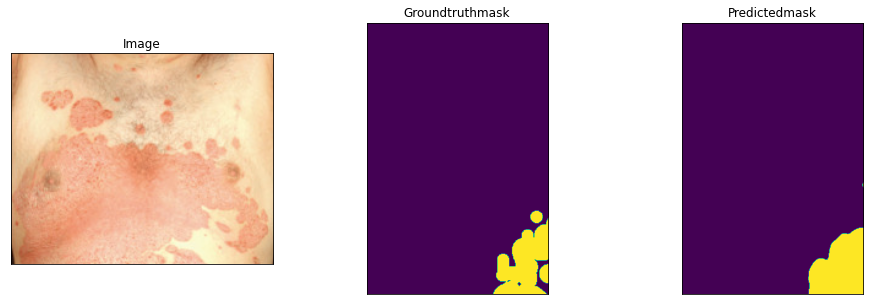

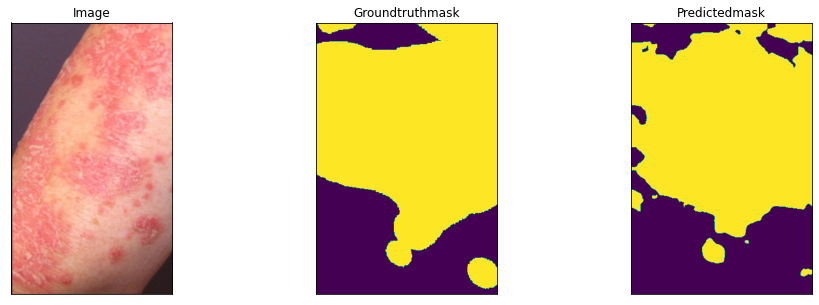

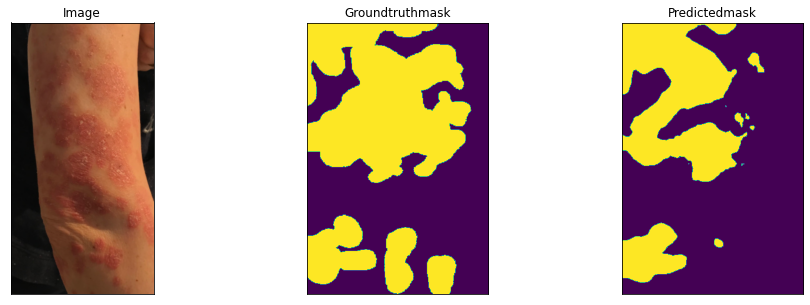

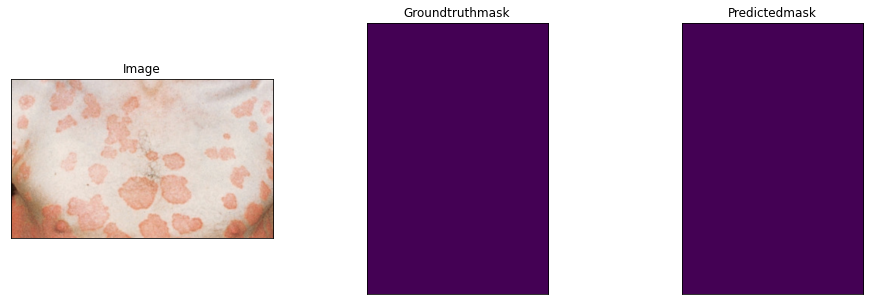

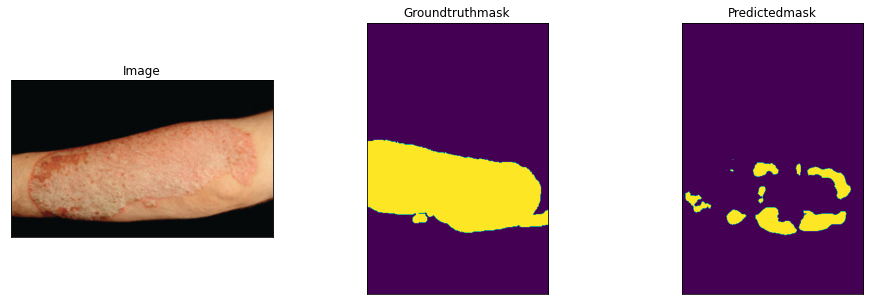

In [18]:
for i in range(5):
    n = np.random.choice(len(testDataset))
    
    imageVis = testDatasetVis[n][0].astype('uint8')
    image, gtMask = testDataset[n]
    
    gtMask = gtMask.squeeze()
    
    xTensor = torch.from_numpy(image).unsqueeze(0)
    prMask = bestModel.predict(xTensor)
    prMask = (prMask.squeeze().cpu().numpy().round())
        
    visualize(
        image=imageVis, 
        groundTruthMask=gtMask, 
        predictedMask=prMask
    )